In [ ]:
!pip install bertopic==0.16.0 datasets==2.16.1 Arabic-Stopwords==0.4.3

In [ ]:
from datasets import load_dataset
import pandas as pd
import re
import random
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

def clean_text(text: str):
    if not isinstance(text, str):
        # raise TypeError("text must be a string")
        return ""

    # remove urls
    text = re.sub(r"http\S+", " رابط ", text)

    # replace any digit with رقم
    text = re.sub(r"\d+", " رقم ", text)

    # set space before and after any punctuation
    text = re.sub(r"([^\w\s])", r" \1 ", text)

    # remove extra spaces
    text = re.sub(r"\s+", " ", text)

    words = word_tokenize(text)
    text = " ".join([ w for w in words if len(w) > 1 ] )

    return text.lower().strip()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
ar_dataset = load_dataset("saudinewsnet")

In [ ]:
ar_dataset['train'][0]

{'source': 'aawsat',
 'url': 'http://aawsat.com/home/article/410826/بريطانيا-أربعة-محاور-لاستراتيجية-جديدة-تتصدى-للتطرف-على-مدى-خمس-سنوات',
 'date_extracted': '2015-07-21 02:51:32',
 'title': 'بريطانيا: أربعة محاور لاستراتيجية جديدة تتصدى للتطرف على مدى خمس سنوات',
 'author': 'لندن: رنيم حنوش',
 'content': 'حدد رئيس الوزراء البريطاني ديفيد كاميرون، اليوم (الاثنين)، ملامح استراتيجية للتصدي للتطرف داخل بريطانيا؛ وهي مسألة اعتبرها كاميرون "صراع جيلنا"، متعهدا خلال خطابه في مدينة بيرمنغهام بالتصدي لهؤلاء الذين ينشرون التطرف بين الشبان المسلمين البريطانيين.\n\n ورسم كاميرون الاطار العام لاستراتيجية مكافحة التطرف التي المقرر ان تنشر كاملة في وقت لاحق هذا العام، والتي تسعى للتصدي لانتشار الأفكار المتطرفة التي يروج لها متشددو تنظيم "داعش".\n\n وحسبما تناقلت وسائل الإعلام البريطانية، فإن خطة رئيس الوزراء ستكون على مدى خمسة أعوام للقضاء على التطرف الداخلي من خلال أربعة محاور، وهي: القضاء على إيديولوجية التطرف، والوقوف في وجه عمليات التجنيد وغسل الأدمغة بالأفكار المتطرفة، وإعادة اصوات الاسلام الم

In [ ]:
raw_dataset = [
    {
        "text": rec["content"],
        "source": rec["source"],
        "date": rec["date_extracted"]
    }
    for rec in ar_dataset['train']
]

In [ ]:
raw_dataset_df = pd.DataFrame( raw_dataset )
raw_dataset_df = raw_dataset_df.sample(frac=1, random_state=101)

In [ ]:
raw_dataset_df.head()

,text,source,date
26442,عين اليوم الدمام عقدت أمانة المنطقة الشرقية ال...,3alyoum,2015-08-09 20:45:39
24574,`` لم نر الإرهاب إلا بعد تسييس الدين ليصير الو...,alwatan,2015-08-07 06:32:39
20441,رغد عشميل عين اليوم عزز فريق ريال مدريد الإسبا...,3alyoum,2015-08-06 19:16:04
7927,أوضحت إدارة مستشفى الدوادمي العام في بيان لها ...,alriyadh,2015-07-24 16:23:27
14012,الشعر الجميل يبقى محفورا في الذاكرة لا يمحي من...,alriyadh,2015-07-31 03:53:17


In [ ]:
raw_dataset_df['text'] = raw_dataset_df['text'].apply(clean_text)

In [ ]:
raw_dataset_df['text_len'] = raw_dataset_df['text'].apply(len)

In [ ]:
raw_dataset_df.head(2)

,text,source,date,text_len
26442,عين اليوم الدمام عقدت أمانة المنطقة الشرقية ال...,3alyoum,2015-08-09 20:45:39,1094
24574,`` لم نر الإرهاب إلا بعد تسييس الدين ليصير الو...,alwatan,2015-08-07 06:32:39,3378


<Axes: xlabel='text_len', ylabel='Count'>

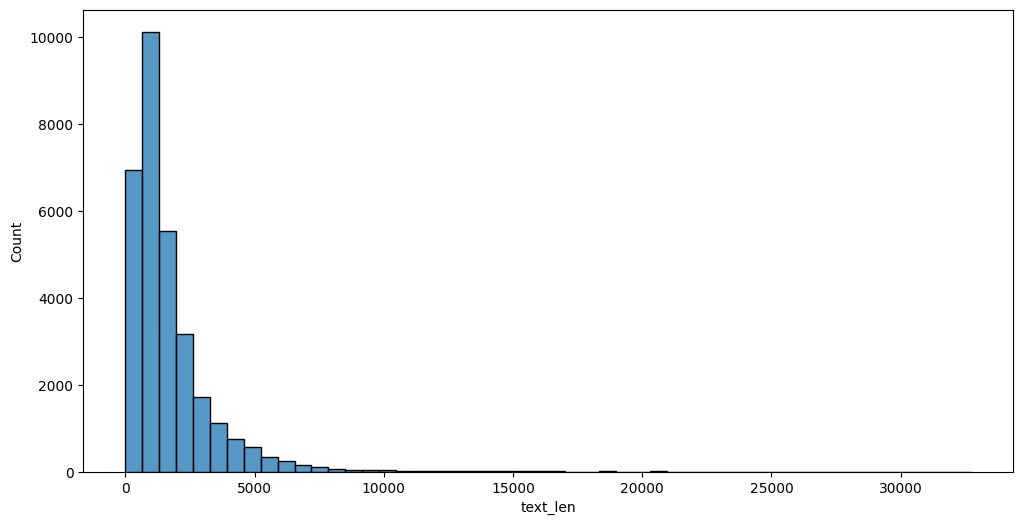

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(raw_dataset_df['text_len'], bins=50)

In [ ]:
print(raw_dataset_df.shape)
raw_dataset_df = raw_dataset_df[ raw_dataset_df['text_len'] <= 10_000 ]
print(raw_dataset_df.shape)

(31030, 4)
(30902, 4)


In [ ]:
print(raw_dataset_df.shape)
raw_dataset_df.drop_duplicates(['text'], inplace=True)
print(raw_dataset_df.shape)

(30902, 4)
(29691, 4)


In [ ]:
raw_dataset_df['datetime_stamp'] = raw_dataset_df['date'].apply(lambda v: datetime.strptime(v, "%Y-%m-%d %H:%M:%S"))

raw_dataset_df['datetime_stamp'] = raw_dataset_df['datetime_stamp'].apply(lambda v: v.replace(hour=0, minute=0, second=0))

## Embedding

In [ ]:
from sentence_transformers import SentenceTransformer

# model_id = "sentence-transformers/distiluse-base-multilingual-cased-v2"
model_id = "sentence-transformers/LaBSE"
embedding_model = SentenceTransformer(model_id, device="cuda:0")

In [ ]:
news_embeddings = embedding_model.encode(raw_dataset_df['text'].values, show_progress_bar=True)

Batches:   0%|          | 0/928 [00:00<?, ?it/s]

In [ ]:
news_embeddings.shape

(29691, 768)

## Dim Reduction

In [ ]:
from umap import UMAP

umap_model = UMAP(n_neighbors=15, n_components=15,
                  min_dist=0.0, metric='cosine',
                  random_state=101)

## Clustering

In [ ]:
from hdbscan import HDBSCAN

# A higher min_cluster_size will generate fewer topics
# A lower min_cluster_size will generate more topics.

hdbscan_model = HDBSCAN(min_cluster_size=50,
                        metric='euclidean',
                        cluster_selection_method='eom',
                        prediction_data=True)

## Vectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import arabicstopwords.arabicstopwords as stp

stop_words = stp.stopwords_list()

vectorizer_model = CountVectorizer(min_df=3,
                                   stop_words=stop_words,
                                   analyzer='word',
                                   max_df=0.5,
                                   ngram_range=(1, 3)
                                   )

## Topic Representer

In [ ]:
from bertopic.representation import KeyBERTInspired

keybert_model = KeyBERTInspired()

representation_model = {
    "KeyBERT": keybert_model
}

## Let's Go

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(
    # Pipeline models
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,

    # Hyperparameters
    top_n_words=10,
    verbose=True
)

topics, probs =  topic_model.fit_transform(
    raw_dataset_df['text'].values,
    news_embeddings
)

2024-01-12 12:18:38,050 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-12 12:19:22,247 - BERTopic - Dimensionality - Completed ✓
2024-01-12 12:19:22,251 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-12 12:19:26,144 - BERTopic - Cluster - Completed ✓
2024-01-12 12:19:26,156 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-01-12 12:20:33,804 - BERTopic - Representation - Completed ✓


In [ ]:
print(
    raw_dataset_df['text'].values[50],
    topics[50], probs[50]
)

topic_model.get_topic(17)

In [ ]:
raw_dataset_df['topic'] = topics
raw_dataset_df['prob'] = probs

In [ ]:
raw_dataset_df[ raw_dataset_df['topic'] == 17 ].head(10)

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,Representative_Docs
0,-1,9929,-1_رقم مليار_بنسبة رقم رقم_السمو الملكي_رقم رق...,"[رقم مليار, بنسبة رقم رقم, السمو الملكي, رقم ر...","[الملك سلمان عبدالعزيز, سلمان عبدالعزيز آل, ال...",[أقر مجلس الوزراء أن يكون لكل شاطئ حرم رقم مفت...
1,0,4099,0_القدم_النادي_الموسم_اللاعب,"[القدم, النادي, الموسم, اللاعب, اللاعبين, لكرة...","[السعودي لكرة القدم, الموسم المقبل, لكرة القدم...",[قدم الأهلي الموسم الماضي أفضل مستوياته وخرج م...
2,1,906,1_عدن_المقاومة_الحوثيين_الحوثي,"[عدن, المقاومة, الحوثيين, الحوثي, اليمن, الشعب...","[مطار عدن, الحوثيين وقوات صالح, عدن, الحوثيين ...",[هبطت طائرة عسكرية سعودية في مطار مدينة عدن جن...
3,2,619,2_إيران_الاتفاق_النووي_الإيراني,"[إيران, الاتفاق, النووي, الإيراني, الاتفاق الن...","[الاتفاق النووي الإيراني, الاتفاق النووي إيران...",[حامد السلمي عين اليوم هل يعيد التاريخ نفسه وي...
4,3,514,3_وإنشاء_البلدية_الأمانة_المرورية,"[وإنشاء, البلدية, الأمانة, المرورية, المشروعات...","[تنفيذ مشروع, مشروعات, المشروعات, وإنشاء, ومشر...",[اعتمد معالي وزير الشئون البلدية والقروية المه...
...,...,...,...,...,...,...
86,85,60,85_كورونا_رقم حالة_فيروس_الفيروس,"[كورونا, رقم حالة, فيروس, الفيروس, وزارة الصحة...","[فيروس كورونا, بفيروس كورونا, أعلنت وزارة الصح...",[أعلنت وزارة الصحة عن تسجيل حالة إصابة واحدة ب...
87,86,56,86_الجمارك_جمرك_تهريب_رجال الجمارك,"[الجمارك, جمرك, تهريب, رجال الجمارك, مخبأة, عا...","[محاولة تهريب, مطار الملك عبدالعزيز, عبدالعزيز...",[إبراهيم الحذيفي عين اليوم تمكن رجال الجمارك ب...
88,87,55,87_حرس_حرس الحدود_البحث والإنقاذ_والإنقاذ,"[حرس, حرس الحدود, البحث والإنقاذ, والإنقاذ, ال...","[فرق البحث والإنقاذ, البحث والإنقاذ, والإنقاذ,...",[باشرت فرق البحث والإنقاذ في قطاعات حرس الحدود...
89,88,53,88_المطعم_مطعم_الطعام_الأطباق,"[المطعم, مطعم, الطعام, الأطباق, الفندق, المطبخ...","[سلسلة مطاعم, المطعم, مطعم, المطاعم, مطاعم, ال...",[أحمد علي سبق القاهرة قدم موقع `` آر دي `` مجم...


In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_heatmap()

In [ ]:
topics_per_class = topic_model.topics_per_class(
    raw_dataset_df['text'].values,
    classes=raw_dataset_df['source'].values,
)

14it [00:26,  1.86s/it]


In [ ]:
topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=20)

In [ ]:
topics_over_time = topic_model.topics_over_time(
    raw_dataset_df['text'].values,
    raw_dataset_df['datetime_stamp'].values
)

18it [01:57,  6.52s/it]


In [ ]:
topic_model.visualize_topics_over_time(
    topics_over_time,
    topics=[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
)

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(
    raw_dataset_df['text'].values
)

100%|██████████| 89/89 [00:01<00:00, 60.71it/s]


In [ ]:
topic_model.visualize_hierarchy(
    hierarchical_topics=hierarchical_topics
)

## Topics Merging

In [ ]:
topics_to_merge = [
    [15, 60, 4],
    [30, 23, 7]
]

topic_model.merge_topics(
    raw_dataset_df['text'].values,
    topics_to_merge
)

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(
    raw_dataset_df['text'].values
)

topic_model.visualize_hierarchy(
    hierarchical_topics=hierarchical_topics
)

100%|██████████| 85/85 [00:01<00:00, 61.99it/s]


## Topics Filtering

In [ ]:
raw_dataset_df.head()

,text,source,date,text_len,datetime_stamp,topic,prob
26442,عين اليوم الدمام عقدت أمانة المنطقة الشرقية ال...,3alyoum,2015-08-09 20:45:39,1094,2015-08-09,-1,0.000000
24574,`` لم نر الإرهاب إلا بعد تسييس الدين ليصير الو...,alwatan,2015-08-07 06:32:39,3378,2015-08-07,-1,0.000000
20441,رغد عشميل عين اليوم عزز فريق ريال مدريد الإسبا...,3alyoum,2015-08-06 19:16:04,1872,2015-08-06,0,1.000000
7927,أوضحت إدارة مستشفى الدوادمي العام في بيان لها ...,alriyadh,2015-07-24 16:23:27,429,2015-07-24,18,0.868492
14012,الشعر الجميل يبقى محفورا في الذاكرة لا يمحي من...,alriyadh,2015-07-31 03:53:17,1049,2015-07-31,-1,0.000000


In [ ]:
filtered_raw_dataset_df = raw_dataset_df[ ~raw_dataset_df['topic'].isin([-1]) ]

## Inference

In [ ]:
story = """
طرحت مؤسسة البترول الكويتية عطاءً؛ لبيع زيت وقود عالي الكبريت للتحميل في الفترة من فبراير/ شباط إلى إبريل/ نيسان.
وأوضحت مصادر تجارية، اليوم الخميس، أن المؤسسة تعرض شحنات من زيت الوقود عالي الكبريت تبلغ الواحدة 60 ألف طن لتحميلها من الكويت شهرياً بالفترة المذكورة.
"""

_topic, _prob =  topic_model.transform([story])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-01-12 13:04:11,397 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-01-12 13:04:31,935 - BERTopic - Dimensionality - Completed ✓
2024-01-12 13:04:31,937 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-01-12 13:04:31,940 - BERTopic - Cluster - Completed ✓


In [ ]:
_topic, _prob

([9], array([0.81851637]))

In [ ]:
topic_model.get_topic(_topic[0])

[('النفط', 0.05428056478685363),
 ('برميل', 0.032093742568892074),
 ('الخام', 0.028630349324321742),
 ('للبرميل', 0.023673960432895356),
 ('رقم دولار', 0.020922791917017926),
 ('رقم رقم دولار', 0.019924493910167998),
 ('أسعار النفط', 0.018867810385048898),
 ('مليون برميل', 0.018486963226617564),
 ('برميل يوميا', 0.01773261084211265),
 ('رقم مليون برميل', 0.017061148649970166)]

In [ ]:
filtered_raw_dataset_df[ filtered_raw_dataset_df['topic'] == _topic[0] ].head()

,text,source,date,text_len,datetime_stamp,topic,prob
20202,نزل النفط إلى أقل مستوى له في ستة أشهر أمس بفع...,okaz,2015-08-04 18:25:51,429,2015-08-04,9,1.000000
155,قالت وزارة البترول المصرية أمس الاثنين إن شركة...,aawsat,2015-07-21 02:56:39,1202,2015-07-21,9,0.598107
30894,سنغافورة رقم شوال رقم هـ الموافق رقم أغسطس رقم...,was,2015-08-11 13:42:28,418,2015-08-11,9,1.000000
19752,ربط خبير اقتصادي تراجع أرباح قطاع البتروكيماوي...,alwatan,2015-08-04 17:55:42,1187,2015-08-04,9,0.666340
19204,كشف وزير البترول المصري شريف إسماعيل أمس أن بل...,aleqtisadiya,2015-08-04 18:31:39,2584,2015-08-04,9,0.669129


## Save and Reload

In [ ]:
model_id = "sentence-transformers/LaBSE"
topic_model.save("/content/safe_bertopic", serialization="safetensors",
                 save_ctfidf=True, save_embedding_model=model_id)

loaded_model = BERTopic.load("/content/safe_bertopic")

In [ ]:
topic_model.save("/content/pickel_bert_topic_news.pkl", serialization="pickle")

loaded_model = BERTopic.load("/content/pickel_bert_topic_news.pkl")